len(samples): 3456
len(set(labels)): 48
train_Y
Number 2: 56, Number 26: 61, Number 44: 60, Number 12: 62, Number 21: 56, Number 41: 65, Number 8: 55, Number 7: 61, Number 13: 51, Number 20: 60, Number 5: 51, Number 1: 58, Number 38: 54, Number 39: 53, Number 46: 60, Number 9: 55, Number 32: 61, Number 22: 54, Number 23: 62, Number 17: 62, Number 45: 64, Number 43: 61, Number 10: 59, Number 27: 51, Number 37: 61, Number 18: 49, Number 29: 58, Number 14: 63, Number 30: 53, Number 31: 56, Number 28: 58, Number 3: 56, Number 33: 53, Number 24: 56, Number 0: 59, Number 15: 54, Number 19: 59, Number 11: 62, Number 16: 56, Number 36: 55, Number 4: 56, Number 35: 58, Number 6: 60, Number 47: 57, Number 40: 60, Number 34: 54, Number 25: 63, Number 42: 56
test_Y
Number 8: 17, Number 39: 19, Number 33: 19, Number 26: 11, Number 2: 16, Number 27: 21, Number 22: 18, Number 17: 10, Number 38: 18, Number 46: 12, Number 11: 10, Number 13: 21, Number 0: 13, Number 10: 13, Number 5: 21, Number 44: 12, 

Using cache found in /home/mambauser/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 1 4.45s: train loss 2.626942, train acc 0.297, test loss 1.576926, test acc 0.509
Epoch 2 1.46s: train loss 1.006824, train acc 0.685, test loss 1.236345, test acc 0.616
Epoch 3 1.38s: train loss 0.671069, train acc 0.778, test loss 0.781434, test acc 0.751
Epoch 4 1.36s: train loss 0.295496, train acc 0.911, test loss 0.412882, test acc 0.848
Epoch 5 1.42s: train loss 0.163265, train acc 0.949, test loss 0.351806, test acc 0.896
Epoch 6 1.54s: train loss 0.150806, train acc 0.957, test loss 0.366242, test acc 0.895
Epoch 7 1.39s: train loss 0.124564, train acc 0.966, test loss 0.315277, test acc 0.909
Epoch 8 1.31s: train loss 0.077434, train acc 0.983, test loss 0.364499, test acc 0.897
Epoch 9 1.24s: train loss 0.041066, train acc 0.991, test loss 0.225334, test acc 0.947
Epoch 10 1.48s: train loss 0.100779, train acc 0.976, test loss 0.430370, test acc 0.883
Epoch 11 1.29s: train loss 0.221582, train acc 0.937, test loss 0.335620, test acc 0.903
Epoch 12 1.28s: train loss 0.1

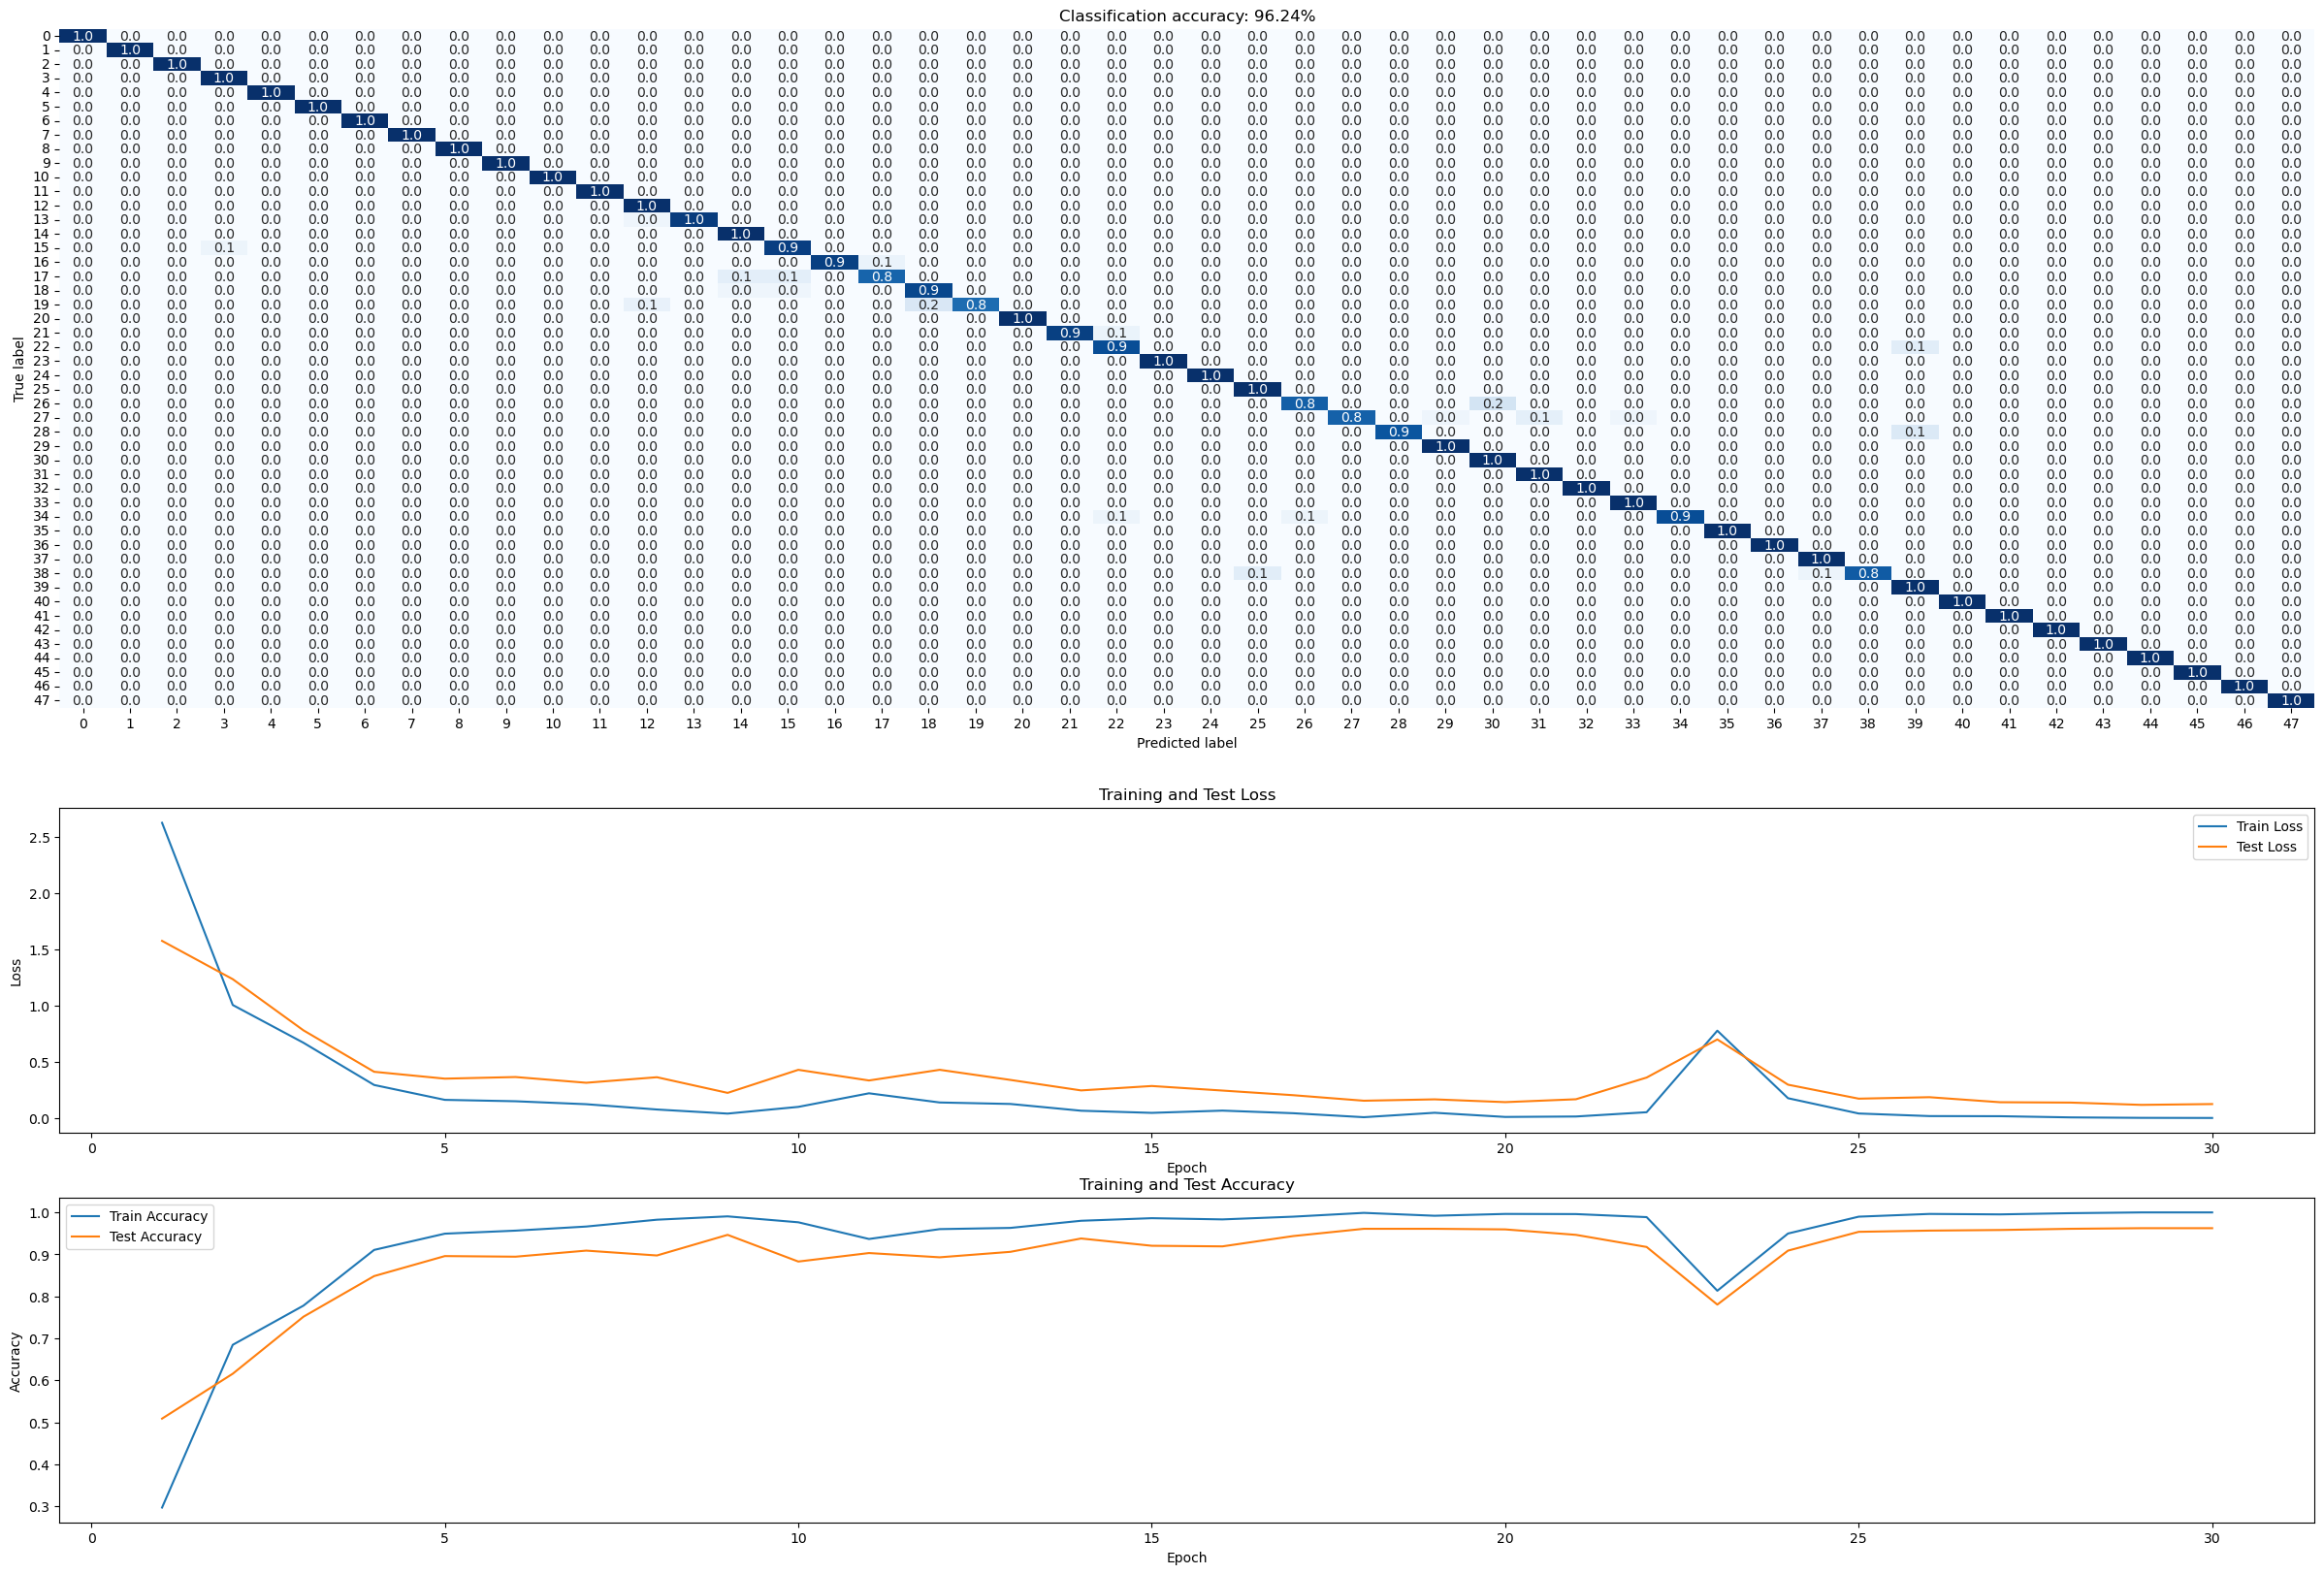

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

from MMClassifyFunc.train import Trainer
from MMClassifyFunc.models import CustomResNet
from MMClassifyFunc.data_preprocess import get_loader_hdf5
from MMClassifyFunc.data_read import get_data_hdf5, get_data_hdf5_nolog
from MMClassifyFunc.visualization import visualize_results

h5_file_path = '/home/mambauser/MMCode/data/stft_1d.h5'
in_channels = 1

samples, labels = get_data_hdf5_nolog(
    h5_file_path=h5_file_path,
    in_channels=in_channels,
    # wordIndex=[0,10,11],
    fileIndex=list(range(0,10))+list(range(12,30))+list(range(32,40)),
    # personIndex=[0],
    txIndex=[0,1],
)

print("len(samples): {}".format(len(samples)))
print("len(set(labels)): {}".format(len(set(labels))))

trainloader, testloader = get_loader_hdf5(samples=samples, labels=labels)

# classifier
classifier = CustomResNet(in_channels=in_channels,
                          num_classes=len(set(labels)),
                          weights=models.ResNet18_Weights.DEFAULT,
                          model='resnet18')

# optimizers
lr = 1e-3
betas = (.5, .99)
optimizer = optim.Adam(classifier.parameters(), lr=lr, betas=betas)
criterion = nn.CrossEntropyLoss()

# train model
NUM_INPUTS = 1
epochs = 30

trainer = Trainer(
    num_inputs=NUM_INPUTS,
    classifier=classifier,
    optimizer=optimizer,
    criterion=criterion,
    print_every=1,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    use_cuda=torch.cuda.is_available(),
    use_scheduler=False)

trainer.train(trainloader=trainloader, testloader=testloader, epochs=epochs)

visualize_results(trainer=trainer)


len(samples): 384
len(set(labels)): 48


Processing batches: 100%|██████████| 2/2 [00:00<00:00, 12.12it/s]


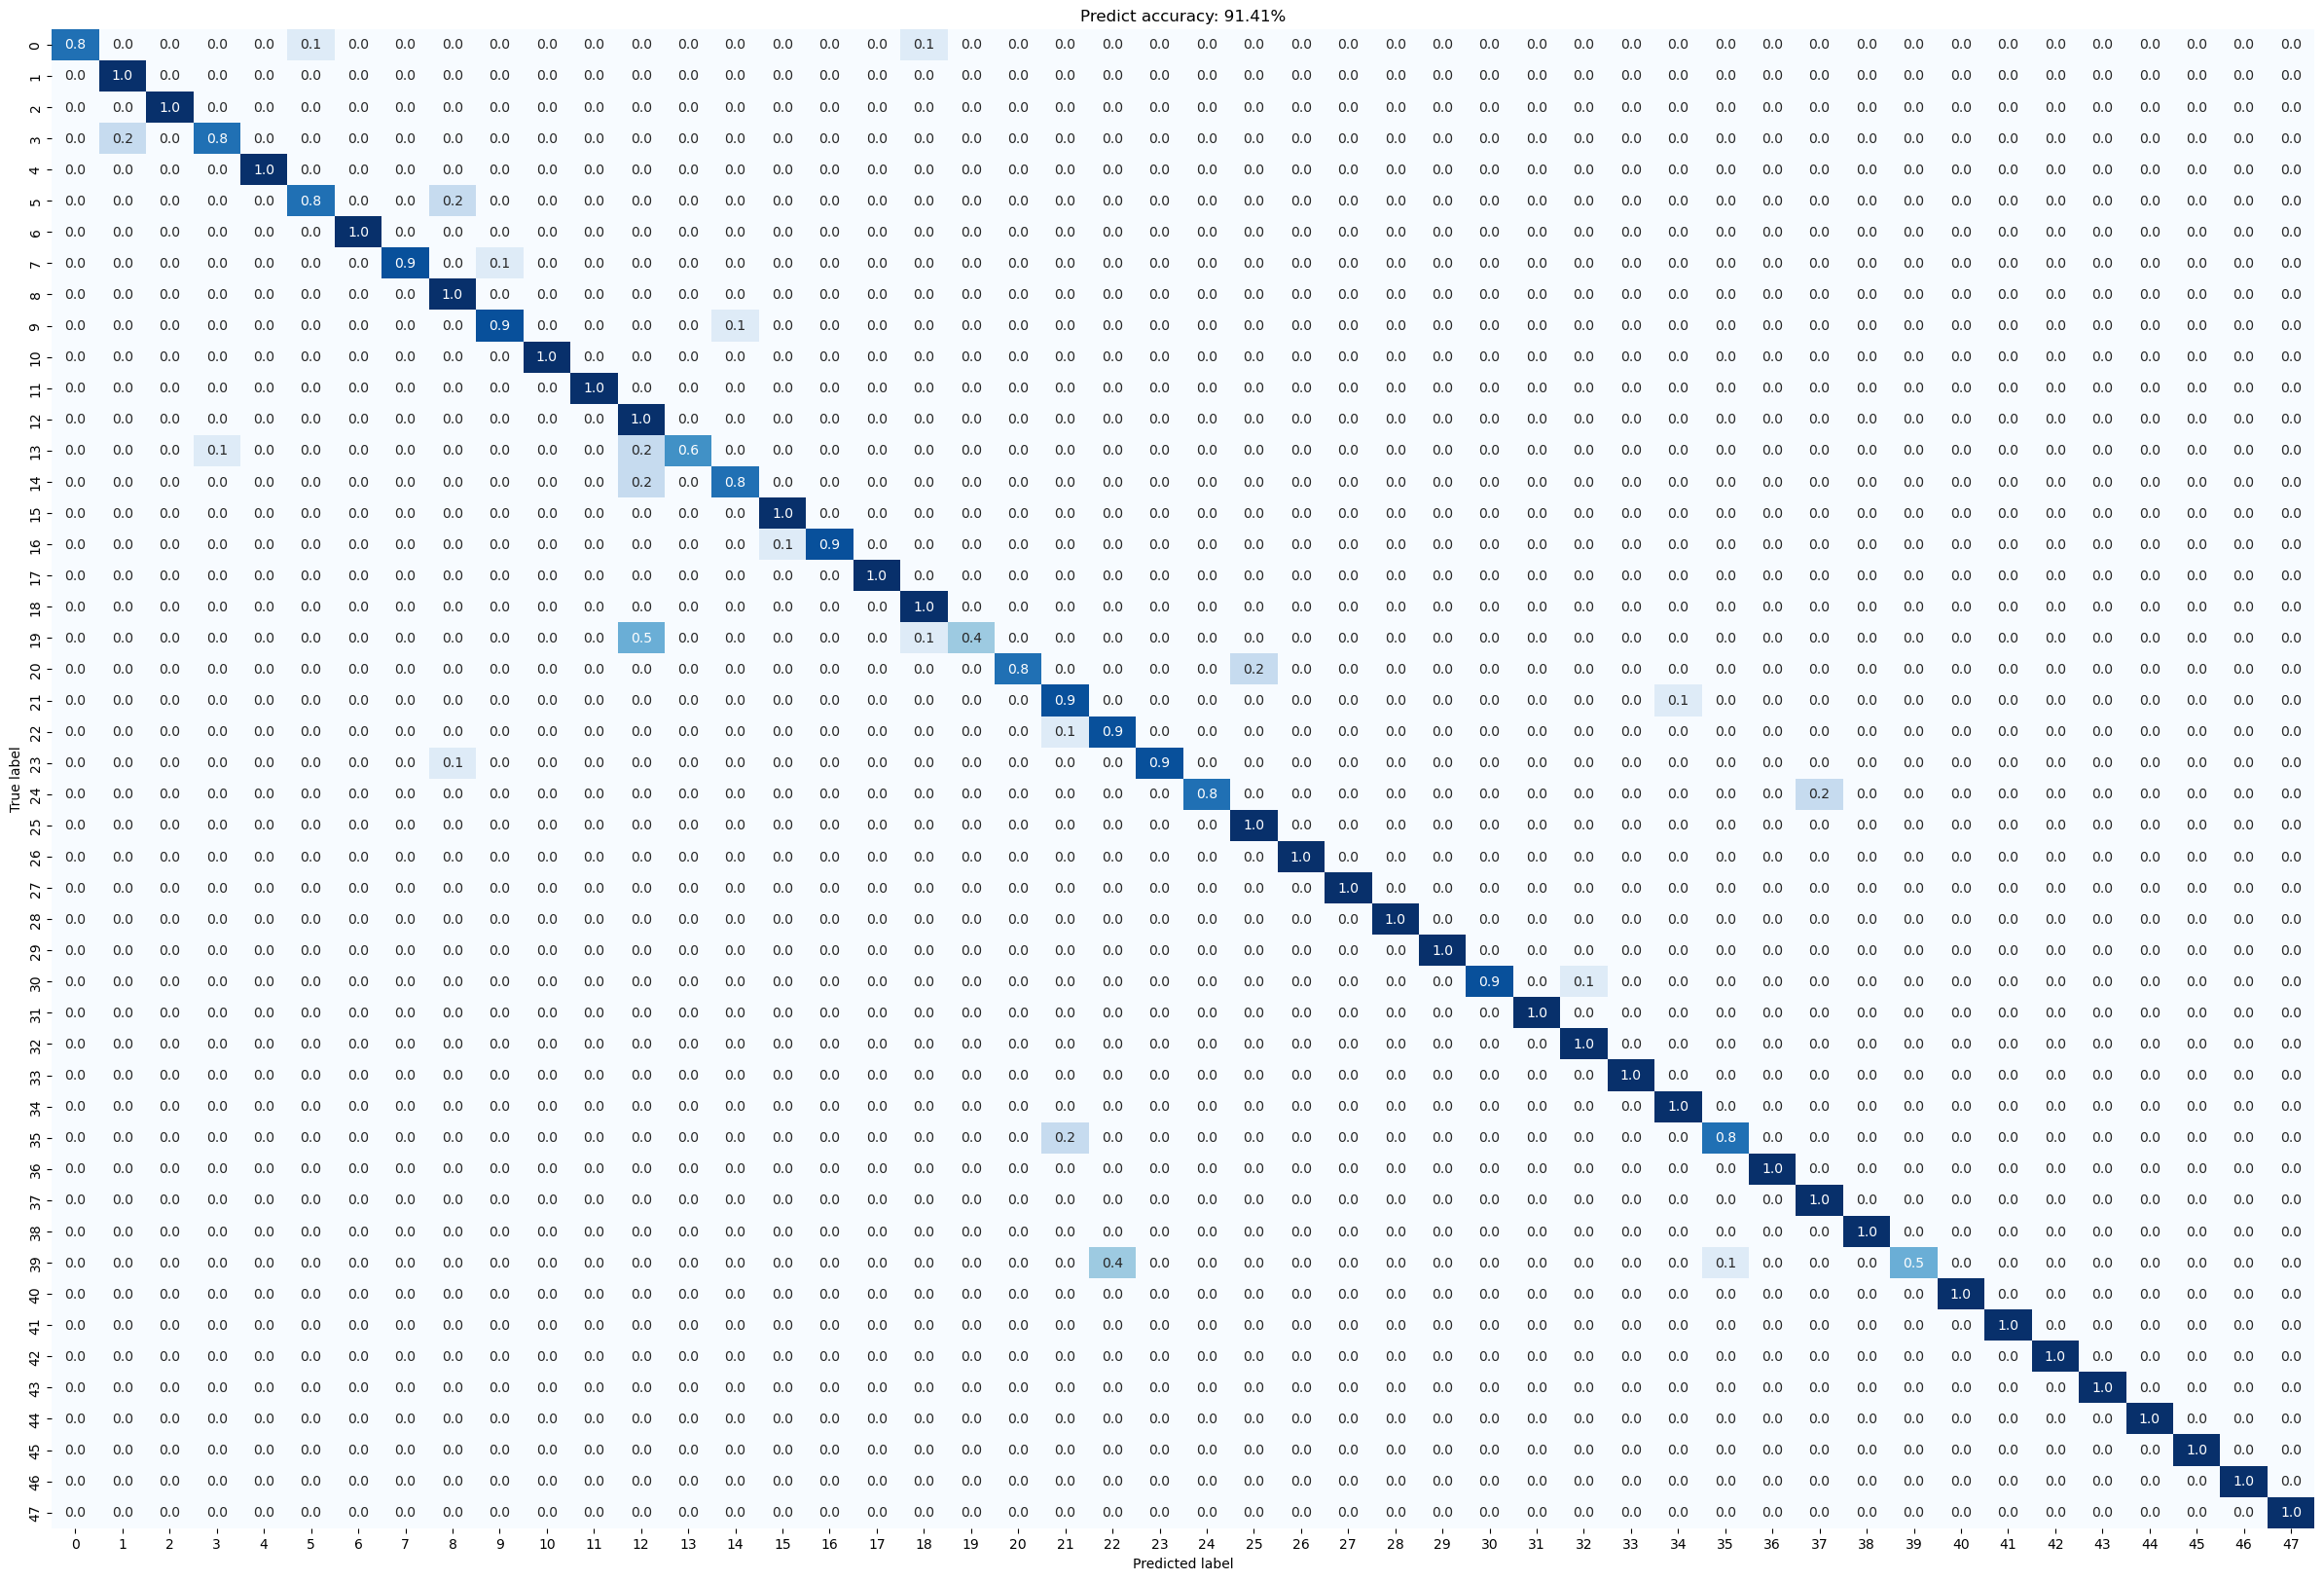

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

from MMClassifyFunc.train import Trainer
from MMClassifyFunc.models import CustomResNet
from MMClassifyFunc.data_preprocess import get_loader_hdf5, get_loader_all_hdf5
from MMClassifyFunc.data_read import get_data_hdf5, get_data_hdf5_nolog
from MMClassifyFunc.visualization import visualize_results, visualize_predict

h5_file_path = "/home/mambauser/MMCode/data/stft_1d.h5"
in_channels = 1

samples, labels = get_data_hdf5_nolog(
    h5_file_path=h5_file_path,
    in_channels=in_channels,
    # wordIndex=[0,10,11],
    fileIndex=[10, 11, 30, 31],
    # personIndex=[0],
    txIndex=[0, 1],
)

print("len(samples): {}".format(len(samples)))
print("len(set(labels)): {}".format(len(set(labels))))

# Create dataset and dataloader
dataloader = get_loader_all_hdf5(samples, labels)

# classifier
trainer.classifier.eval()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# classifier.to(device)
trainer.classifier.to(device)

# Prepare for evaluation
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in tqdm(dataloader, desc="Processing batches"):
        images, labels = images.to(device), labels.to(device)
        outputs = trainer.classifier(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

visualize_predict(all_labels, all_preds)